### Creating, Evaluating and Deploying an ARIMA forecasting model

#### ARIMA - Autoregressive Integrated Moving Average

##### Introduction

ARIMA is an statistical method widely used for time series forecasting. Widely used for predicting the time-dependent data through 3 key components:

**Autoregressive** - Used to model the relationship between an observation and it's lagged values.

**Integrated** - Involves differencing to achieve statioinarity.

**Moving Average** - Used to model the relationship between an observation and residual errors from moving average model.

The order of the parameters is represented by letters p, d, q. determining how many lagged observations, differencing steps, and lagged forecast errors are considered in the model, respectively.

The model is using a SARIMA a variant of ARIMA which deals with the seasonal data.

For a data science team charged with creating this model, they will usually undergo a set of key tasks:

0. Installation and Imports
1. Load the data from the Lakehouse.
2. Data Exploration and analysis to understand the characteristics, any underlying trend or seasonal pattern.
3. Stationarize the Time series.
4. Differencing the data to remove the trend and seasonality.
5. Check for any residual errors. 
6. Identifying the parameters p, d, q.
7. Fitting the ARIMA model.
8. Forcasting for some nearby time period.
9. Evaluation of the model.
10. Forecasting the future values.


##### Step 0: Installation and Imports

This code used to add functionality to our own programs without having to write it all from scratch. Examples of libraries include statsmodel librarie, graph plotting libraries, and web application frameworks.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 16
import warnings
import itertools
warnings.filterwarnings("ignore")

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 5, Finished, Available)

##### Step 1: Loading the dataset on which the model will be built

In [2]:
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
#df = pd.read_csv("/lakehouse/default/Files/CO2-emission/new_CO2_emissions_dataset_3.csv", parse_dates=['YYYYMM'], date_parser=dateparse)
df = spark.sql("SELECT * FROM #BRONZE_LAKEHOUSE_NAME#.co2_emissions")
display(df)

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 6, Finished, Available)

SynapseWidget(Synapse.DataFrame, 861d9b6e-ca38-403a-bc66-ac777bca1cdc)

In [3]:
from datetime import datetime, timedelta
df["YYYYMM"] = df["YYYYMM"] - timedelta(days = 365 * 0)
df = df[df["YYYYMM"]<"2023-10-01"]
df.set_index('YYYYMM', inplace=True)

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 7, Finished, Available)

##### Step 1.1: Converting the dates from string to numeric datetime values to index it  correctly 

In [4]:
timeseries = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
timeseries['CO2_emissions'] = pd.to_numeric(timeseries['CO2_emissions'], errors = 'coerce')
timeseries.dropna(inplace = True)

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 8, Finished, Available)

In [5]:
timeseries_gr = timeseries.groupby('Description')
timeseries_gr.head(5)

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 9, Finished, Available)

,MSN,CO2_emissions,Column_Order,Description,Unit
YYYYMM,,,,,
1983-01-01,CLEIEUS,72.076,1,Scope 1 and 2 CO2 emissions - Location Based,Million Metric Tons of Carbon Dioxide
1983-02-01,CLEIEUS,64.442,1,Scope 1 and 2 CO2 emissions - Location Based,Million Metric Tons of Carbon Dioxide
1983-03-01,CLEIEUS,64.084,1,Scope 1 and 2 CO2 emissions - Location Based,Million Metric Tons of Carbon Dioxide
1983-04-01,CLEIEUS,60.842,1,Scope 1 and 2 CO2 emissions - Location Based,Million Metric Tons of Carbon Dioxide
1983-05-01,CLEIEUS,61.798,1,Scope 1 and 2 CO2 emissions - Location Based,Million Metric Tons of Carbon Dioxide
1983-01-01,NNEIEUS,12.175,2,Gross quantity of direct (scope 1) CO2 emissio...,Million Metric Tons of Carbon Dioxide
1983-02-01,NNEIEUS,11.708,2,Gross quantity of direct (scope 1) CO2 emissio...,Million Metric Tons of Carbon Dioxide
1983-03-01,NNEIEUS,13.994,2,Gross quantity of direct (scope 1) CO2 emissio...,Million Metric Tons of Carbon Dioxide
1983-04-01,NNEIEUS,14.627,2,Gross quantity of direct (scope 1) CO2 emissio...,Million Metric Tons of Carbon Dioxide


##### Step 2: EDA-Exploratory data analysis

EDA is a process where Data Scientist communicate with the data for the first time and understand the weight of the data like, how the data represented, whether there are any missing or degraded values in the data through visualization and some techniques.

Exploratory Data Analysis (EDA) examines and explores a given data set to uncover patterns, draw conclusions, and identify meaningful insights. This process requires analyzing the data to summarize and visualize to understand the data better.

EDA for the CO2 emission dataset is to :
1. Look at the contribution of Each source in emitting carbon dioxide in a bar graph and a pie chart

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 10, Finished, Available)

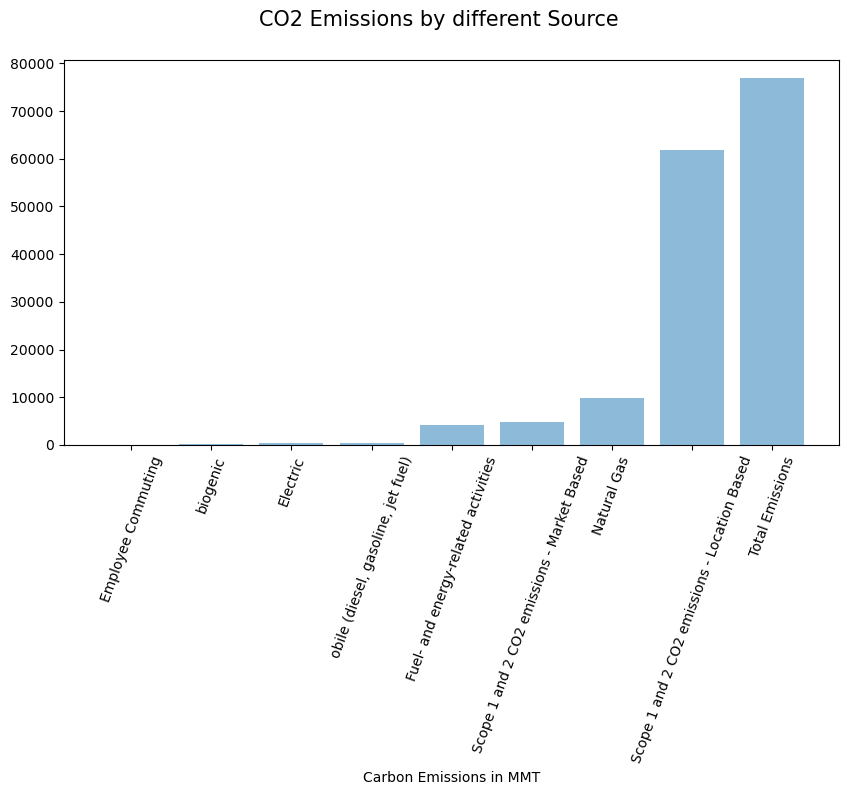

In [6]:
CO2_per_source = timeseries.groupby('Description')['CO2_emissions'].sum().sort_values()
cols = ['Employee Commuting', 'biogenic', 'Electric','obile (diesel, gasoline, jet fuel)',
        'Fuel- and energy-related activities', 'Scope 1 and 2 CO2 emissions - Market Based', 'Natural Gas', 
        'Scope 1 and 2 CO2 emissions - Location Based', 'Total Emissions']

fig = plt.figure(figsize = (10,5))
x_label = cols
x_tick = np.arange(len(cols))
plt.bar(x_tick, CO2_per_source, align = 'center', alpha = 0.5)
fig.suptitle("CO2 Emissions by different Source", fontsize= 15)
plt.xticks(x_tick, x_label, rotation = 70, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Carbon Emissions in MMT', fontsize = 10)
plt.show()

please upload to lakehouse

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 11, Finished, Available)

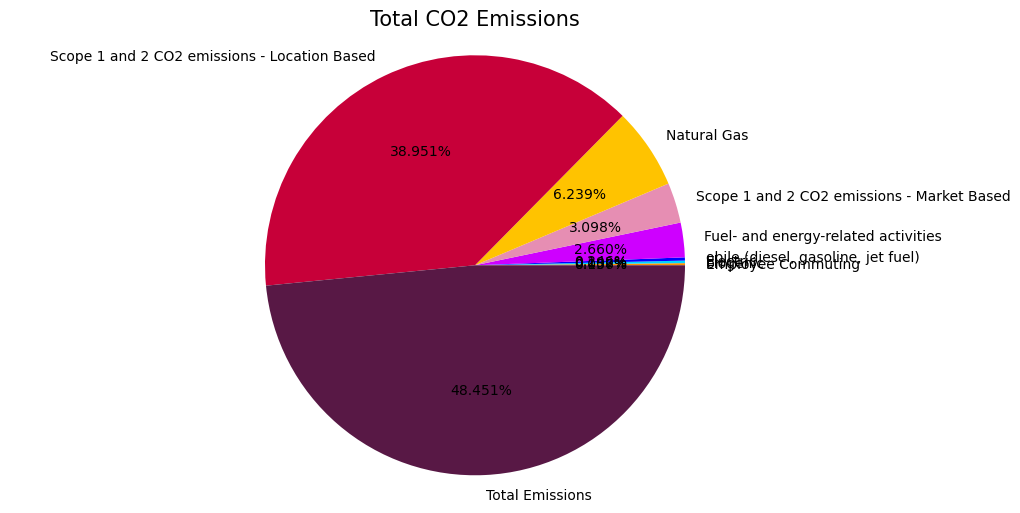

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.pie(CO2_per_source, labels=cols, autopct='%1.3f%%', startangle=0, colors=['#7CC90E','#FF9100','#00D5FF', '#0000FF', '#CE00FF', '#E68EB3', '#FFC300', '#C70039', '#581845'])
ax.axis('equal')
ax.set_title("Total CO2 Emissions", fontsize=15)
plt.show()

please upload to lakehouse

please upload to lakehouse

##### Step 2.2: Taking sample contribution of any single source and calculating the frequency of CO2 generated. Plotting the graph for the same.

In [8]:
Emissions = timeseries.iloc[:,1:]
Emissions = Emissions.groupby(['Description', pd.Grouper(freq='M')])['CO2_emissions'].sum().unstack(level=0)
monthlytotalemission = Emissions['Total CO2 Emissions']
monthlytotalemission.head()

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 12, Finished, Available)

YYYYMM
1983-01-31    111.621
1983-02-28     99.185
1983-03-31     99.112
1983-04-30     93.183
1983-05-31     98.012
Freq: M, Name: Total CO2 Emissions, dtype: float64

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 13, Finished, Available)

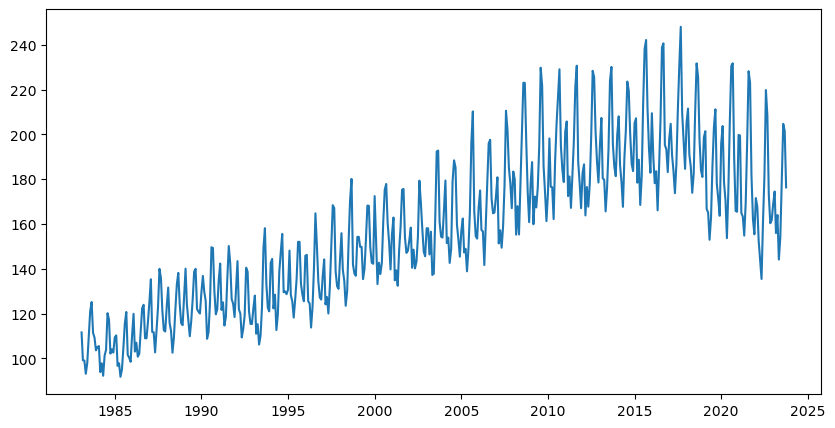

In [9]:
fig = plt.figure(figsize = (10,5))
plt.plot(monthlytotalemission)

please upload to lakehouse

##### Step 3: Stationarize the Time series.

Stationarizing the time series data is necessary to transform  data so that its statistical properties remain constant over time, exhibiting a constant mean, variance, autocovariance structure. Making it more open to modeling and analysis.Involving Differencing, Logarithmic transformations or other mathematical operations.

- ##### TestStationaryPlot()
Designed to visualize the stationarity of a time series data. It takes a DataFrame (df) as input. The function calculates the rolling mean and rolling standard deviation of the data with a window size of 12 (indicating a yearly average in this context). It then plots the original data in green, the rolling mean in blue, and the rolling standard deviation in red. The x-axis represents time in years, and the y-axis represents the total emissions. The function provides a clear graphical representation of how the mean and variability of the data change over time. This visualization is helpful in assessing whether the data is stationary or if further preprocessing, like differencing, may be necessary for accurate modeling and forecasting.


In [10]:
def TestStationaryPlot(df):
    rol_mean = df.rolling(window = 6, center = False).mean()
    rol_std = df.rolling(window = 6, center = False).std()
    plt.figure(figsize = (10,5))

    plt.plot(df, color = 'green',label = 'Original Data')
    plt.plot(rol_mean, color = 'blue', label = 'Rolling Mean')
    plt.plot(rol_std, color ='red', label = 'Rolling Std')
    plt.xticks(fontsize = 7)
    plt.yticks(fontsize = 7)
   

    plt.xlabel('Time in Years', fontsize = 15)
    plt.ylabel('Total Emissions', fontsize = 15)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 15)
    plt.show(block= True)

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 14, Finished, Available)

- ##### TestStationaryAdfuller()

Checks whether a given time series data (df) is stationary or not. It does this using the Augmented Dickey-Fuller test, which is a statistical hypothesis test for stationarity. The function prints out the test results, including the test statistic, p-value, number of lags used, and critical values.

If the p-value is less than or equal to a specified cutoff (default is 0.01), it suggests strong evidence against the null hypothesis. In this case, it indicates that the data has no unit root and is considered stationary. Conversely, if the p-value is greater than the cutoff, there's weak evidence against the null hypothesis, suggesting the time series has a unit root, making it non-stationary.

In simpler terms, this function helps determine whether a time series is stable over time (stationary) or if it exhibits trends or patterns that change over time (non-stationary).


In [11]:
def TestStationaryAdfuller(df, cutoff = 0.01):
    df_test = adfuller(df, autolag = 'AIC')
    df_test_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in df_test[4].items():
        df_test_output['Critical Value (%s)'%key] = value
    print(df_test_output)

    if df_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 15, Finished, Available)

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 16, Finished, Available)

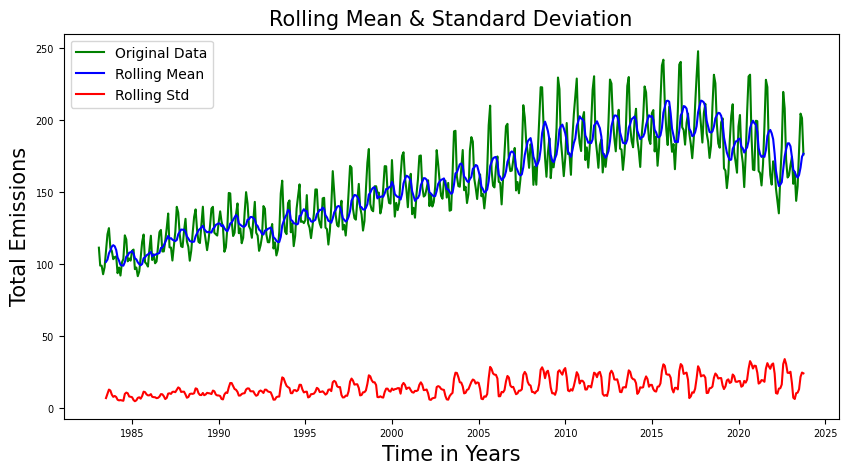

In [12]:
TestStationaryPlot(monthlytotalemission)

In [13]:
TestStationaryAdfuller(monthlytotalemission, cutoff = 0.01)

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 17, Finished, Available)

Test Statistic                  -1.748888
p-value                          0.406116
#Lags Used                      14.000000
Number of Observations Used    474.000000
Critical Value (1%)             -3.444221
Critical Value (5%)             -2.867657
Critical Value (10%)            -2.570028
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


##### Step 3.1: Plotting graph for specific source's CO2 emission.
1. Plotting graph for one of the source the testing for its contribution in CO2 emission.
2. Checking the monthly average difference. 

##### Step 3.1.1:  Plotting graph for one of the source, checking for its contribution in CO2 emissions

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 18, Finished, Available)

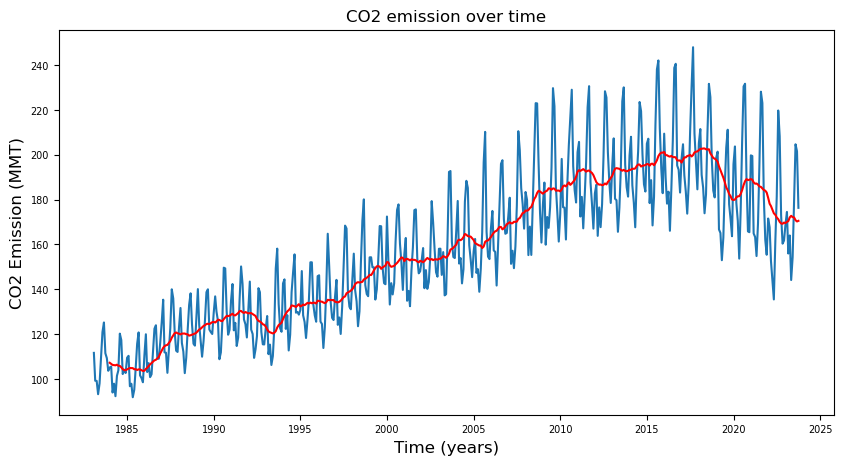

In [14]:
moving_avg = monthlytotalemission.rolling(12).mean()
plt.figure(figsize = (10,5))
plt.plot(monthlytotalemission)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)

plt.xlabel('Time (years)', fontsize = 12)
plt.ylabel('CO2 Emission (MMT)', fontsize = 12)
plt.title('CO2 emission over time', fontsize = 12)
plt.show()

please upload to lakehouse

##### Step 3.1.2: Calculating and plotting the monthly total emissions average difference.

In [15]:
monthlytotalemission_moving_avg_diff = monthlytotalemission - moving_avg
monthlytotalemission_moving_avg_diff.head(13)

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 19, Finished, Available)

YYYYMM
1983-01-31         NaN
1983-02-28         NaN
1983-03-31         NaN
1983-04-30         NaN
1983-05-31         NaN
1983-06-30         NaN
1983-07-31         NaN
1983-08-31         NaN
1983-09-30         NaN
1983-10-31         NaN
1983-11-30         NaN
1983-12-31   -2.107083
1984-01-31   -1.158500
Freq: M, Name: Total CO2 Emissions, dtype: float64

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 20, Finished, Available)

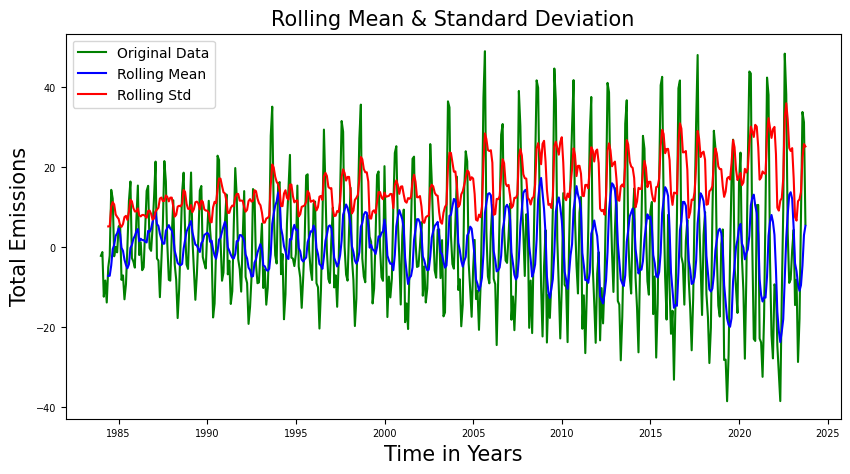

In [16]:
monthlytotalemission_moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(monthlytotalemission_moving_avg_diff)

In [17]:
TestStationaryAdfuller(monthlytotalemission_moving_avg_diff)

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 21, Finished, Available)

Test Statistic                -6.367555e+00
p-value                        2.389075e-08
#Lags Used                     1.400000e+01
Number of Observations Used    4.630000e+02
Critical Value (1%)           -3.444553e+00
Critical Value (5%)           -2.867803e+00
Critical Value (10%)          -2.570106e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


##### Step 3.1.1:  Plotting graph for other source, checking for its contribution in CO2 emissions

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 22, Finished, Available)

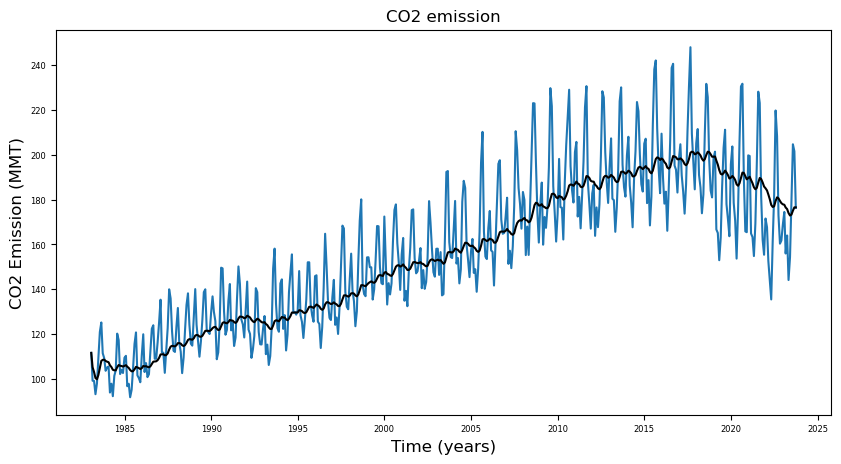

In [18]:
mte_exp_weighted_avg = monthlytotalemission.ewm(halflife=12).mean()
plt.figure(figsize = (10,5))
plt.plot(monthlytotalemission)
plt.plot(mte_exp_weighted_avg, color='black')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('Time (years)', fontsize=12)
plt.ylabel('CO2 Emission (MMT)', fontsize=12)
plt.title('CO2 emission', fontsize=12)
plt.show()

##### Step 3.1.2: Calculating and plotting the monthly total emissions average difference.

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 23, Finished, Available)

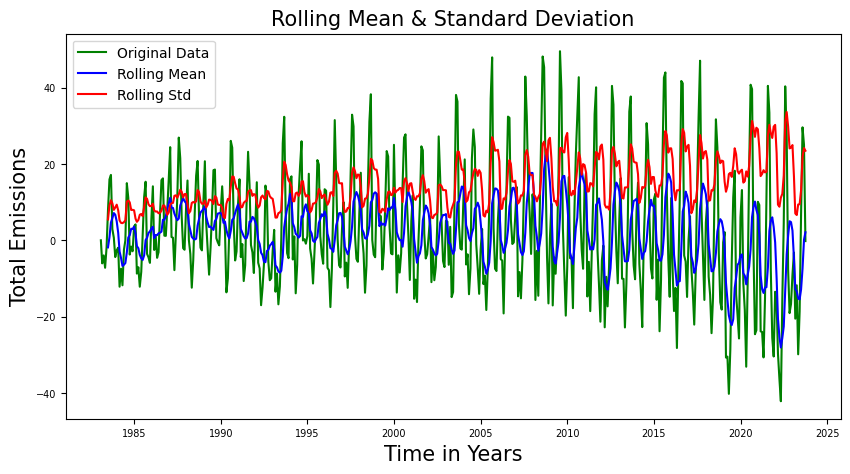

In [19]:
mte_ewma_diff = monthlytotalemission - mte_exp_weighted_avg
TestStationaryPlot(mte_ewma_diff)

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 24, Finished, Available)

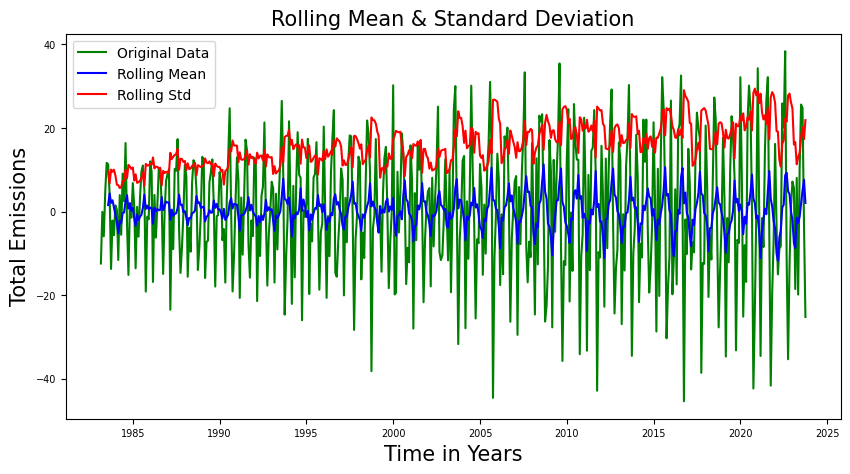

In [20]:
mte_first_difference = monthlytotalemission - monthlytotalemission.shift(1)
TestStationaryPlot(mte_first_difference.dropna(inplace=False))

In [21]:
TestStationaryAdfuller(mte_first_difference.dropna(inplace=False))

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 25, Finished, Available)

Test Statistic                -6.689465e+00
p-value                        4.144851e-09
#Lags Used                     1.300000e+01
Number of Observations Used    4.740000e+02
Critical Value (1%)           -3.444221e+00
Critical Value (5%)           -2.867657e+00
Critical Value (10%)          -2.570028e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 26, Finished, Available)

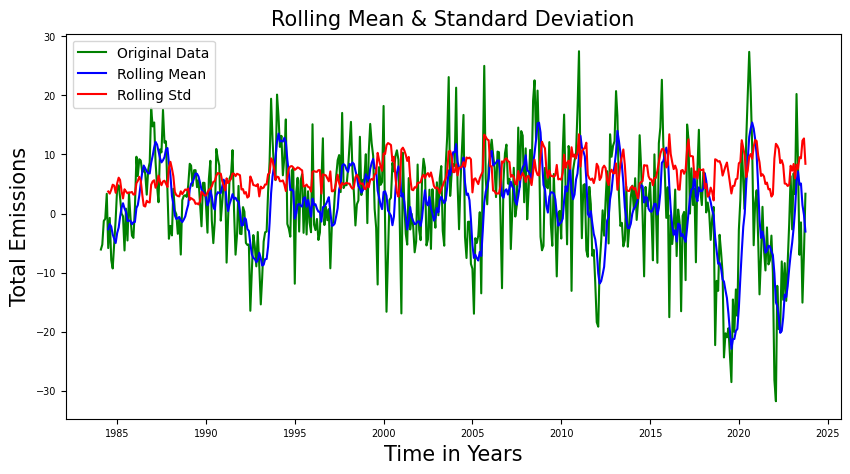

Test Statistic                -6.032234e+00
p-value                        1.409002e-07
#Lags Used                     1.200000e+01
Number of Observations Used    4.640000e+02
Critical Value (1%)           -3.444522e+00
Critical Value (5%)           -2.867789e+00
Critical Value (10%)          -2.570099e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [22]:
mte_seasonal_difference = monthlytotalemission - monthlytotalemission.shift(12)
TestStationaryPlot(mte_seasonal_difference.dropna(inplace=False))
TestStationaryAdfuller(mte_seasonal_difference.dropna(inplace=False))

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 27, Finished, Available)

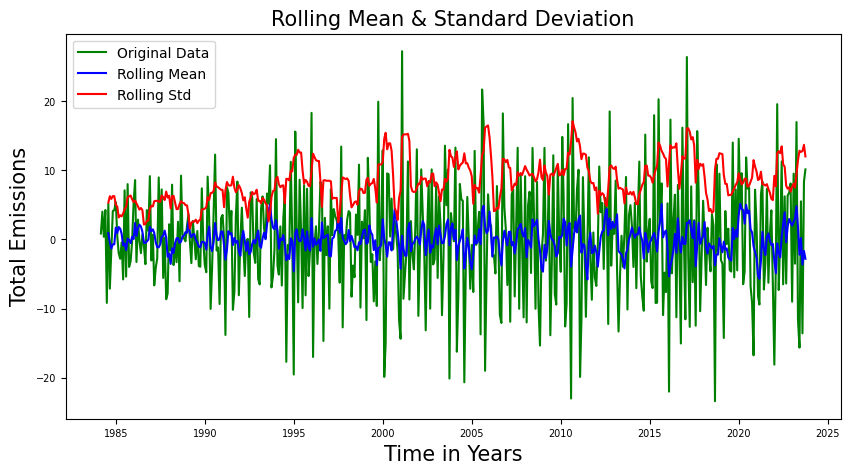

In [23]:
mte_seasonal_first_difference = mte_first_difference - mte_first_difference.shift(12)
TestStationaryPlot(mte_seasonal_first_difference.dropna(inplace=False))

please upload to lakehouse

In [24]:
mte_seasonal_first_difference.dropna(inplace = True)
mte_seasonal_first_difference.head()

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 28, Finished, Available)

YYYYMM
1984-02-29    0.834
1984-03-31    4.002
1984-04-30    0.365
1984-05-31    4.235
1984-06-30   -9.186
Freq: M, Name: Total CO2 Emissions, dtype: float64

##### Step 4: Differencing the timeseries into trend, seasonal and residual component.

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 29, Finished, Available)

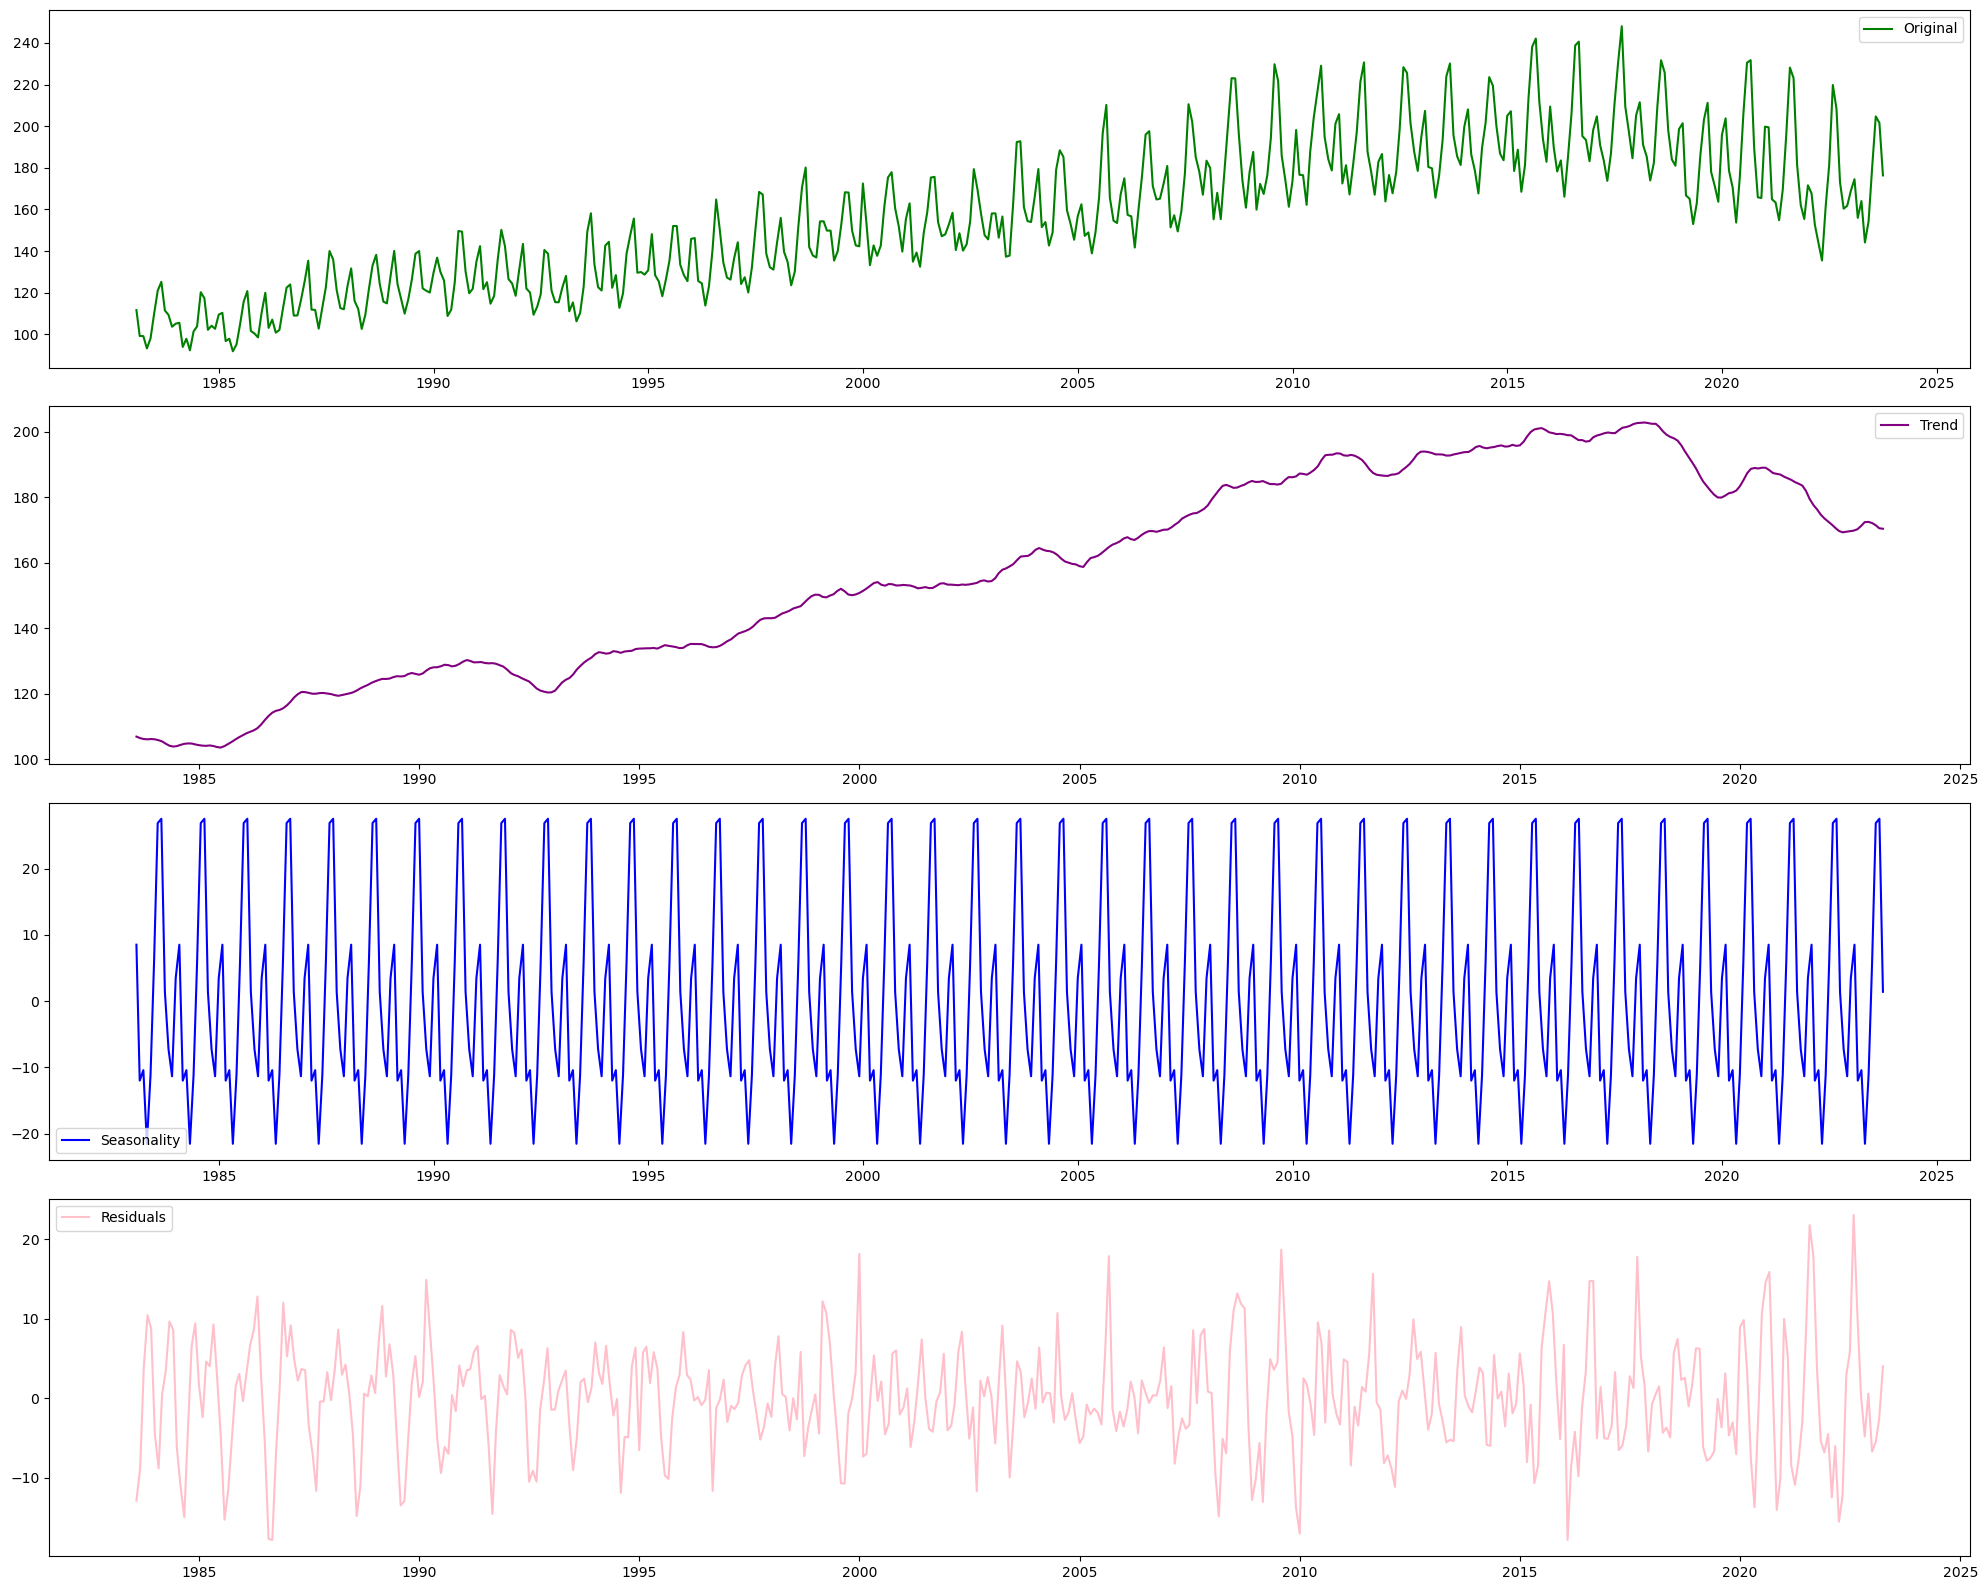

In [25]:
decomposition = seasonal_decompose(monthlytotalemission)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(monthlytotalemission, label='Original', color='green')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='purple')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='pink')
plt.legend(loc='best')
plt.tight_layout()

##### Step 5: Check for residual errors. 

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 30, Finished, Available)

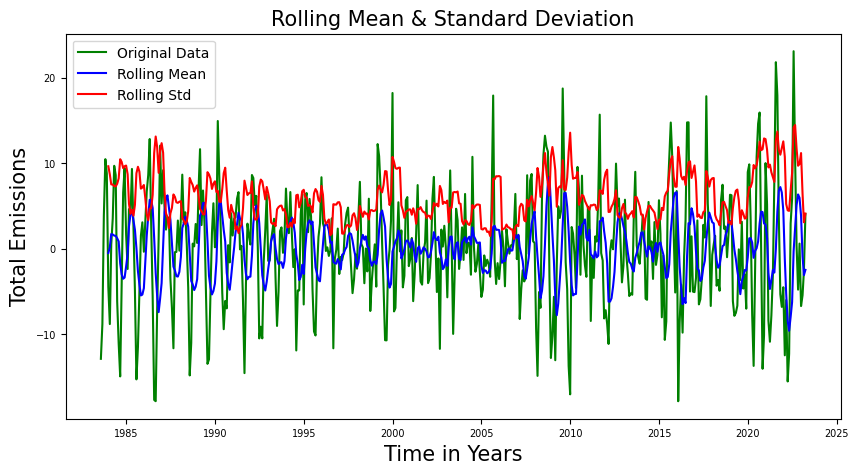

Test Statistic                -9.601321e+00
p-value                        1.917172e-16
#Lags Used                     1.400000e+01
Number of Observations Used    4.620000e+02
Critical Value (1%)           -3.444584e+00
Critical Value (5%)           -2.867816e+00
Critical Value (10%)          -2.570113e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [26]:
mte_decompose = residual
mte_decompose.dropna(inplace=True)
TestStationaryPlot(mte_decompose)
TestStationaryAdfuller(mte_decompose)

##### Step 5.1: Plotting ACF and PACF for the residual errors.

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 31, Finished, Available)

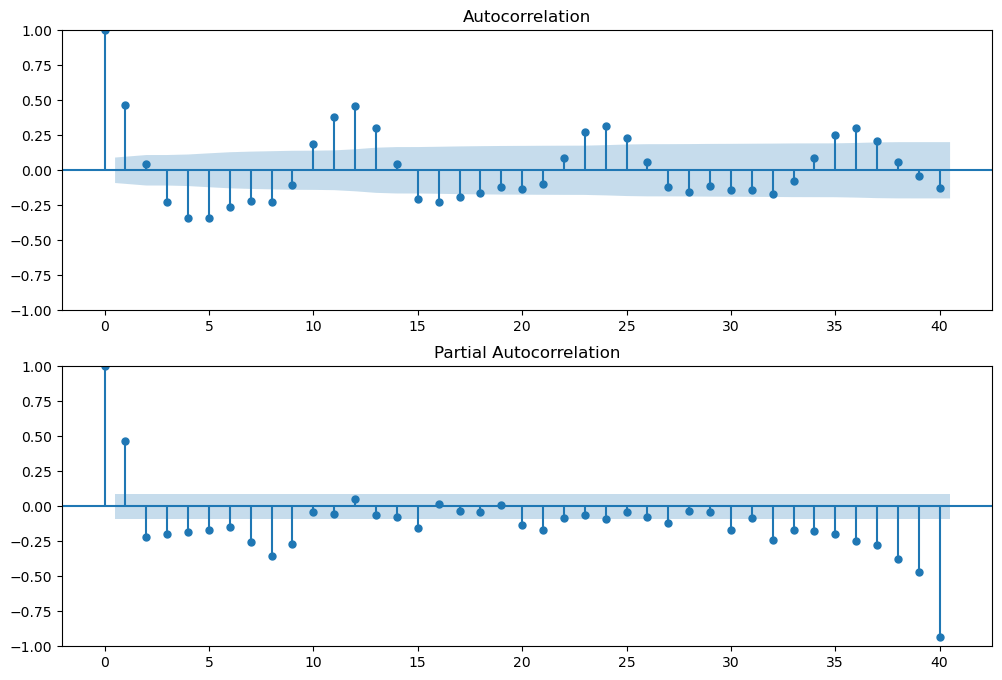

In [27]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mte_decompose.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mte_decompose.iloc[13:], lags=40, ax=ax2)

##### Step 5.2: Plotting ACF and PACF for monthly total emission of seasonal first difference.

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 32, Finished, Available)

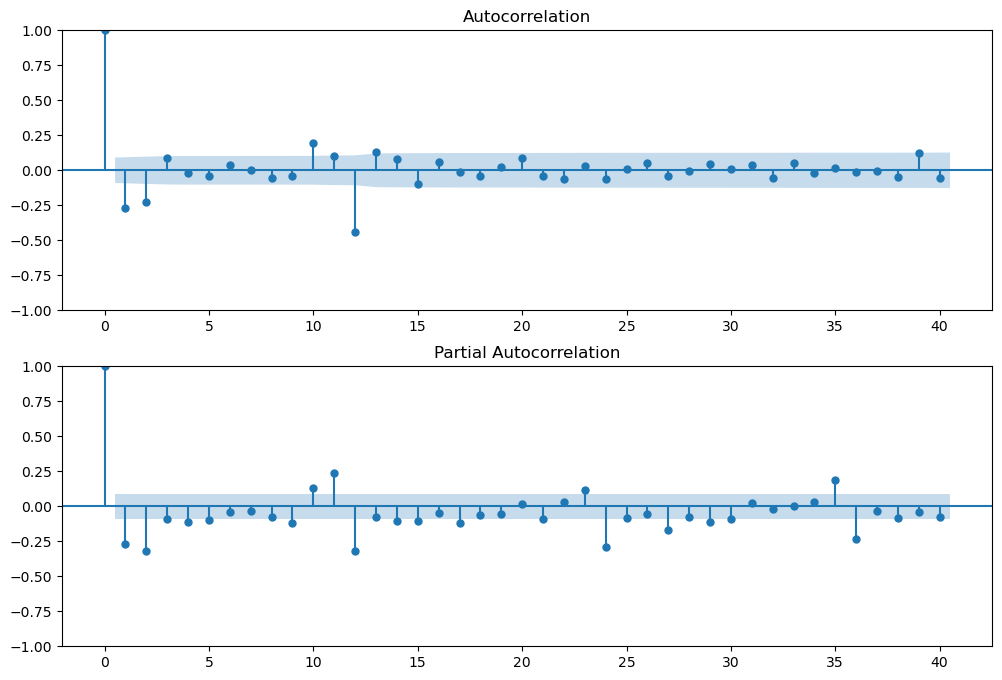

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

##### Step 6: Identifying or setting the parameters p, d, q.
- p represents the autoregressive (AR) order.
- d represents the differencing (I) order.
- q represents the moving average (MA) order.

In [29]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 33, Finished, Available)

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 2) x (0, 0, 2, 12)


##### Step 7: Fitting the ARIMA model for the P, D, Q Parameters using grid search. 

In [30]:
for param in pdq:
    try:
        mod = sm.tsa.ARIMA(monthlytotalemission, order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
            continue

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 34, Finished, Available)

ARIMA(0, 0, 0) - AIC:4852.67630170954


ARIMA(0, 0, 1) - AIC:4394.139640531619


ARIMA(0, 0, 2) - AIC:4171.957904472067


ARIMA(0, 0, 3) - AIC:4042.14234003981


ARIMA(0, 1, 0) - AIC:4078.1668766619514


ARIMA(0, 1, 1) - AIC:4059.6419542263866


ARIMA(0, 1, 2) - AIC:3950.3573077965993


ARIMA(0, 1, 3) - AIC:3888.4954116656186


ARIMA(0, 2, 0) - AIC:4316.9792592255835


ARIMA(0, 2, 1) - AIC:4078.977150333079


ARIMA(0, 2, 2) - AIC:4060.0989591686766


ARIMA(0, 2, 3) - AIC:3942.3508263181675


ARIMA(0, 3, 0) - AIC:4756.238569649746


ARIMA(0, 3, 1) - AIC:4317.342021175708


ARIMA(0, 3, 2) - AIC:4086.408042731453


/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 3, 3) - AIC:4066.9676544921845


ARIMA(1, 0, 0) - AIC:4065.8447748641565


ARIMA(1, 0, 1) - AIC:4035.300606727748


ARIMA(1, 0, 2) - AIC:3963.996162919632


ARIMA(1, 0, 3) - AIC:3902.2667724901617


ARIMA(1, 1, 0) - AIC:4066.157489899704


ARIMA(1, 1, 1) - AIC:3993.6773231966063


ARIMA(1, 1, 2) - AIC:3929.0064440515603


ARIMA(1, 1, 3) - AIC:3888.95347749077


ARIMA(1, 2, 0) - AIC:4285.862018735086


ARIMA(1, 2, 1) - AIC:4066.629125802378


ARIMA(1, 2, 2) - AIC:4059.1947587870645


ARIMA(1, 2, 3) - AIC:4059.6614646589996


ARIMA(1, 3, 0) - AIC:4564.911880077973


ARIMA(1, 3, 1) - AIC:4286.708386108175


ARIMA(1, 3, 2) - AIC:4316.145250548587


ARIMA(1, 3, 3) - AIC:4089.2849363409605


ARIMA(2, 0, 0) - AIC:4040.286486792821


ARIMA(2, 0, 1) - AIC:4040.7051107034167


ARIMA(2, 0, 2) - AIC:3942.775359130795


ARIMA(2, 0, 3) - AIC:3902.7107103766266


ARIMA(2, 1, 0) - AIC:4031.2531227246795


ARIMA(2, 1, 1) - AIC:3865.0224600934175


ARIMA(2, 1, 2) - AIC:3736.9760256435043


ARIMA(2, 1, 3) - AIC:3796.033749182714


ARIMA(2, 2, 0) - AIC:4276.681207458684


ARIMA(2, 2, 1) - AIC:4032.249477621207


ARIMA(2, 2, 2) - AIC:4060.6077901099156


/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 3) - AIC:4010.2666263345945


ARIMA(2, 3, 0) - AIC:4533.458545671592


ARIMA(2, 3, 1) - AIC:4277.825832696369


ARIMA(2, 3, 2) - AIC:4279.9881532685895


/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 3, 3) - AIC:4155.173557123051


ARIMA(3, 0, 0) - AIC:4020.9528297550487


ARIMA(3, 0, 1) - AIC:4037.7270486107227


/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2) - AIC:3753.4736526659635


/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3) - AIC:3809.765367298457


ARIMA(3, 1, 0) - AIC:3917.445849441792


ARIMA(3, 1, 1) - AIC:3843.261303727744


ARIMA(3, 1, 2) - AIC:3736.904531361573


/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3) - AIC:3748.003026220128


ARIMA(3, 2, 0) - AIC:4205.739728310633


ARIMA(3, 2, 1) - AIC:3919.3315015172866


ARIMA(3, 2, 2) - AIC:3836.8972012674876


/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 2, 3) - AIC:3733.7896825744842


ARIMA(3, 3, 0) - AIC:4513.606182104933


ARIMA(3, 3, 1) - AIC:4207.671121137707


/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 3, 2) - AIC:4279.347730911886


/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 3, 3) - AIC:4157.332435810253


##### Step 7.1: Using ARIMAX (Autoregressive Integrated Moving Average with Exogenous Regressors) to set order for the autoregressive, differencing, and moving average components, fitting the data without enfocing the stationary and convertibility constraints. 

In [31]:
mod = sm.tsa.ARIMA(monthlytotalemission, order=(3, 2, 3))
results = mod.fit()
print(results.summary())

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 35, Finished, Available)

/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                SARIMAX Results                                
Dep. Variable:     Total CO2 Emissions   No. Observations:                  489
Model:                  ARIMA(3, 2, 3)   Log Likelihood               -1859.895
Date:                 Thu, 22 Feb 2024   AIC                           3733.790
Time:                         12:22:53   BIC                           3763.108
Sample:                     01-31-1983   HQIC                          3745.307
                          - 09-30-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8216      0.053     15.524      0.000       0.718       0.925
ar.L2         -0.8222      0.053    -15.385      0.000      -0.927      -0.717
ar.L3         -0.1764      0.053     -3.323 

##### Step 7.2: Visualizing the results of grid search

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 36, Finished, Available)

<AxesSubplot: ylabel='Density'>

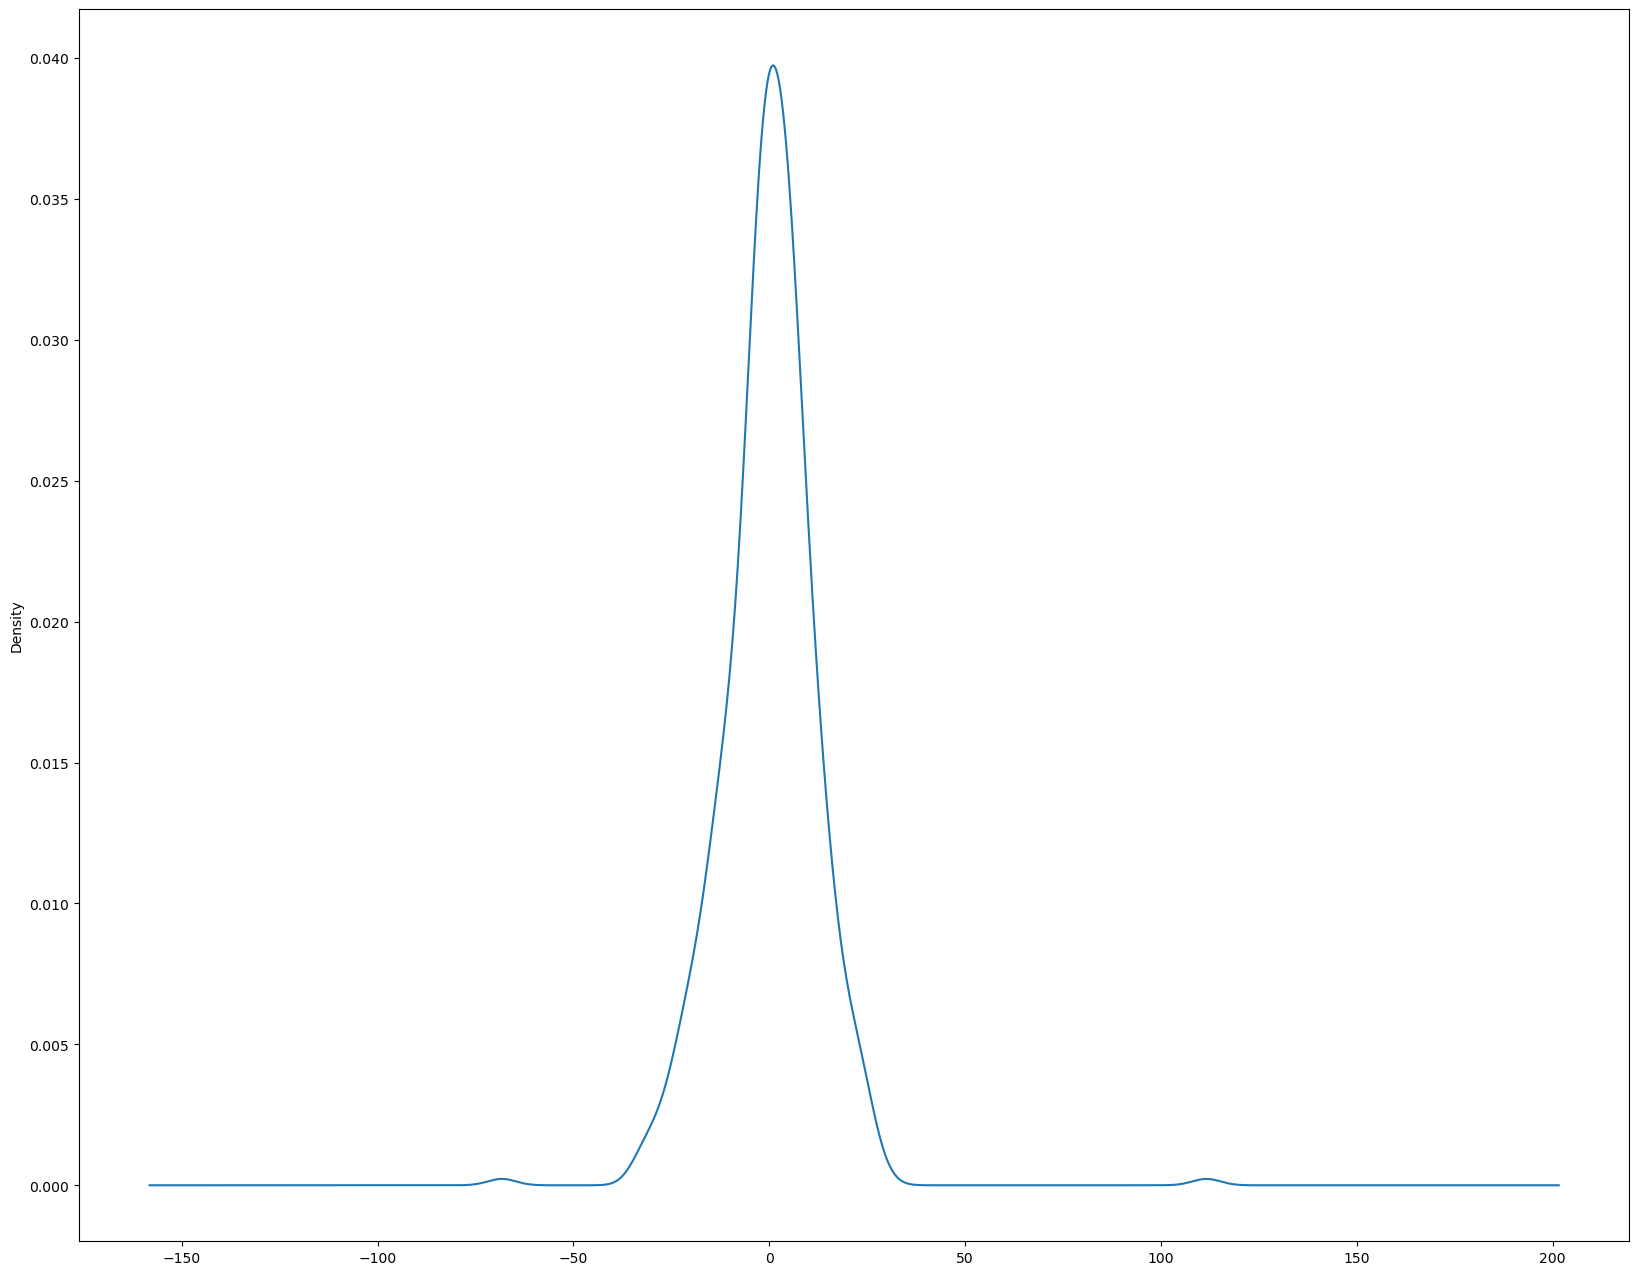

In [32]:
LB = sm.stats.diagnostic.acorr_ljungbox(results.resid,lags = [5,10])
results.resid.plot(kind='kde')

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 37, Finished, Available)

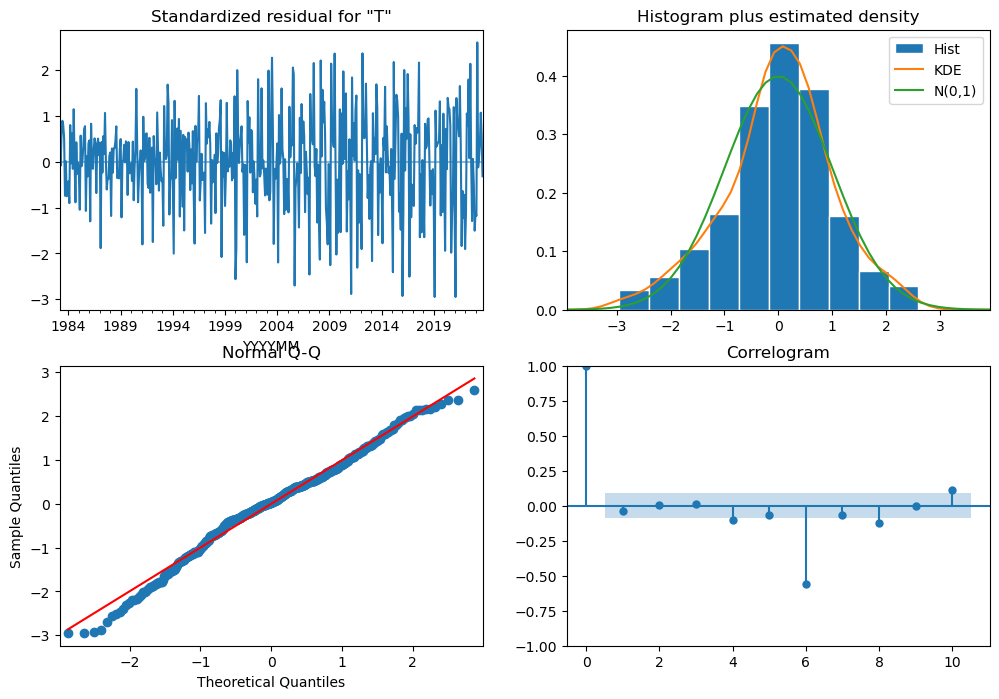

In [33]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

##### Step 8: Forcasting for some nearby time period.

In [34]:
pred = results.get_prediction(start = 480, end = 523, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 38, Finished, Available)

,lower Total CO2 Emissions,upper Total CO2 Emissions
2023-01-31,165.189206,208.076150
2023-02-28,147.419395,190.306246
2023-03-31,114.131021,157.017780
2023-04-30,124.038635,166.925302
2023-05-31,131.829328,174.715904


StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 39, Finished, Available)

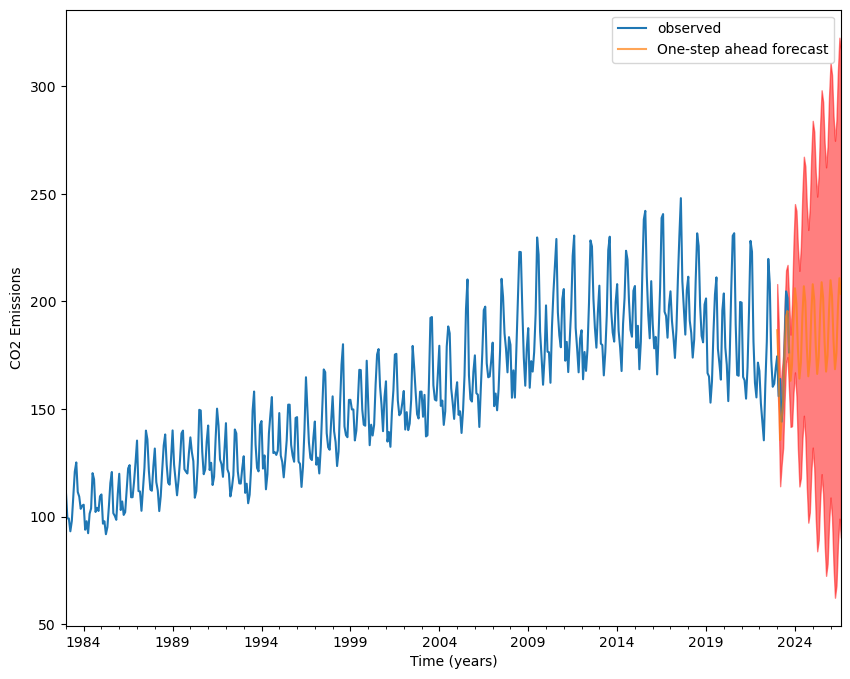

In [35]:
ax = monthlytotalemission['1983':].plot(label='observed', figsize=(10, 8))
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.5)

ax.set_xlabel('Time (years)')
ax.set_ylabel('CO2 Emissions')
plt.legend()

plt.show()

In [36]:
mte_forecast = pred.predicted_mean
mte_truth = monthlytotalemission['2013-01-31':]

# Compute the mean square error
mse = ((mte_forecast - mte_truth) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((mte_forecast-mte_truth)**2)/len(mte_forecast))))

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 40, Finished, Available)

The Mean Squared Error (MSE) of the forecast is 147.69
The Root Mean Square Error (RMSE) of the forcast: nan


In [37]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2013-01-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 41, Finished, Available)

##### Step 9: Evaluation of the prediction

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 42, Finished, Available)

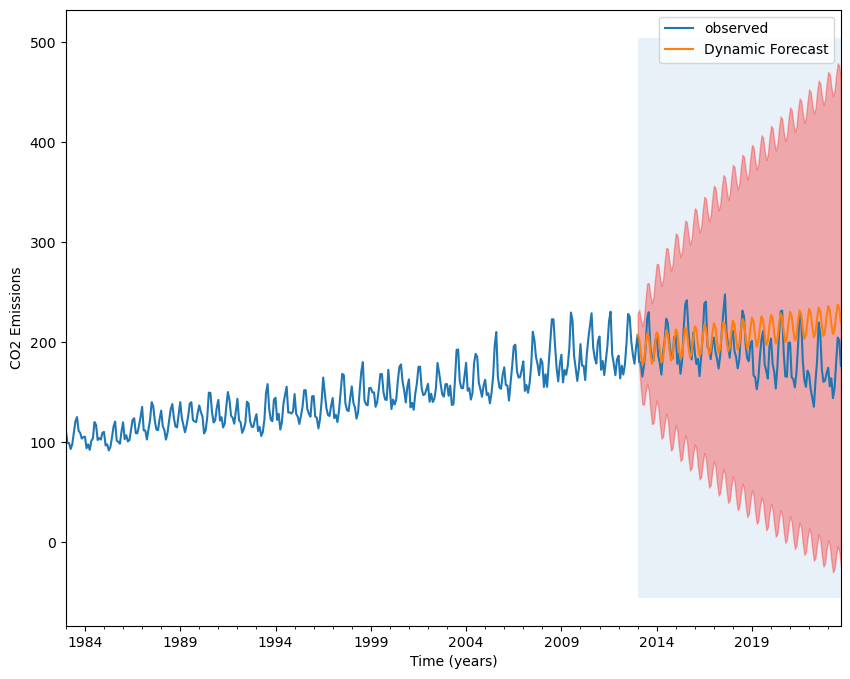

In [38]:
ax = monthlytotalemission['1983':].plot(label='observed', figsize=(10, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1],
                color='r',
                alpha=.3)

ax.fill_betweenx(ax.get_ylim(),
                 pd.to_datetime('2013-01-31'),
                 monthlytotalemission.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('CO2 Emissions')

plt.legend()
plt.show()

In [39]:
mte_forecast = pred_dynamic.predicted_mean
mte_orginal = monthlytotalemission['2016-01-31':]

# Compute the mean square error
mse = ((mte_forecast - mte_orginal) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((mte_forecast-mte_orginal)**2)/len(mte_forecast))))

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 43, Finished, Available)

The Mean Squared Error (MSE) of the forecast is 1217.03
The Root Mean Square Error (RMSE) of the forcast: nan


##### Step 10: Forecasting the future values.

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 44, Finished, Available)

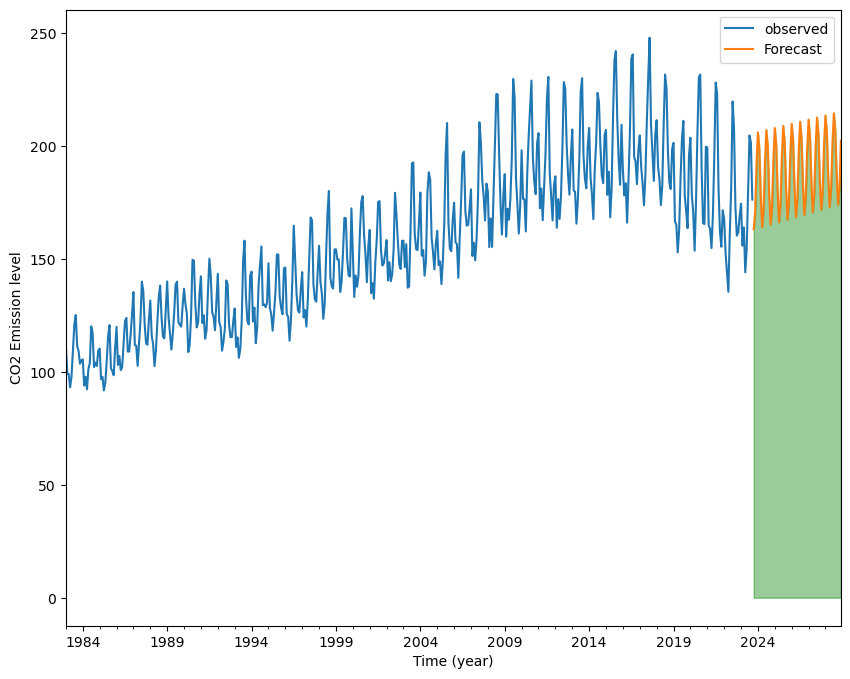

In [40]:
# forecast = results.get_forecast(steps= 60)
forecast = results.predict(start='2023-10-10', end='2024-12-31', dynamic=True)  # Adjust the date range as needed
ax = monthlytotalemission.plot(label='observed', figsize=(10, 8))
forecast.plot(ax=ax, label='Forecast')
ax.fill_between(forecast.index,
                # forecast.iloc[:, 0],
                list(forecast), color='g', alpha=.4)


ax.set_xlabel('Time (year)')
ax.set_ylabel('CO2 Emission level')

plt.legend()
plt.show()

please upload to lakehouse

##### Step 10: Forecasted result store back to OneLake

In [41]:
# Delta table
forecast.write.mode("overwrite").option("overwriteSchema", "true").format("delta").save("Files/co2emmisionforecast")

#forecast.to_csv("/lakehouse/default/Files/CO2-emission/forecasted_CO2_emissions.csv")

StatementMeta(, 59f384dd-7a13-4c2d-8b14-9050a2f13d5e, 45, Finished, Available)